In [1]:
import math
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from functions import *
from model import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Imports loaded! Using device: {device}')
print('=====')
!nvidia-smi

Imports loaded! Using device: cuda
=====
Fri Dec 22 07:16:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 530.41.03    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1080 Ti      On | 00000000:DB:00.0 Off |                  N/A |
| 29%   41C    P5               13W / 180W|      2MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+--------------------------

# Hamiltonian Generative Models

## Definitions

We have some $\{\eta_0\}$, a scheme of integration time. We define $\eta$ to be some small constant.

The standard Hamiltonian Flow with $f(x) = \frac{1}{2}x^2$ has the closed-form solution

$$x_{k+1} =  \cos( \eta_k ) x_{k} + \sin( \eta_k ) \xi_k \quad \text{ and } \quad v_{k+1} = -\sin( \eta_k) x_{k}  + \cos( \eta_k ) \xi_k.$$

By a recursive expansion, we know

$$x_{k} = x_0 \left(\Pi_{j=0}^{k-1} \cos \eta_j   \right) + \sum_{j=0}^{k-1} \xi_j \left( \Pi_{s=j+1}^{k-1} \cos \eta_s \right) \sin \eta_j.$$

So we produce the definitions

$$\alpha_{k}:= (\cos \eta_j)^k  \quad \text{ and } \quad \beta_{k}:= 1 - \alpha_k^2$$

# Dataloading

In [7]:
# MNIST Dataset
# 60000 training images, digits 0-9, black & white 32x32 images and normalized to [-1, 1]
root_dir = './data/'
mnist_transform = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ])
dataset = MNIST(root=root_dir, train=True, transform=mnist_transform, download=True)
dataloader = DataLoader(dataset=dataset, batch_size=256, shuffle=True, num_workers=4)
in_channels = 1

In [8]:
# Uniform Dataset
# Uniform colors, default image size 32x32 with 11 classes normalized to [-1, 1]
num_samples = 60000
uniform_dataset = UniformDataset(num_samples)
data_loader = DataLoader(uniform_dataset, batch_size=256, shuffle=True)
in_channels = 1

In [ ]:
# CIFAR10 Dataset
root_dir = './data/'
cifar_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
dataset = CIFAR10(root=root_dir, train=True, transform=cifar_transform, download=True)
dataloader = DataLoader(dataset=dataset, batch_size=512, shuffle=True,num_workers=10)
in_channels = 3

In [2]:
num_timesteps = 1000
model = load_model('models/arccos-0.999.pt', num_timesteps)

# Model Training

In [10]:
learning_rate = 1e-3
num_epochs = 50
num_timesteps = 1000
eta_const = math.acos(0.999)

etas, alphas, betas = get_parameters(eta_const, num_timesteps)

In [11]:
network = UNet(in_channels=in_channels)
network = network.to(device)
model = Hamiltonian(network, num_timesteps, device=device, etas=etas, betas=betas, alphas=alphas)
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
training_loop(model, dataloader, optimizer, num_epochs, num_timesteps, device=device)

  0%|          | 0/235 [00:00<?, ?it/s]

# Output

In [3]:
generated = generate_image(model, 49, 1, 32)

  0%|          | 0/1000 [00:00<?, ?it/s]

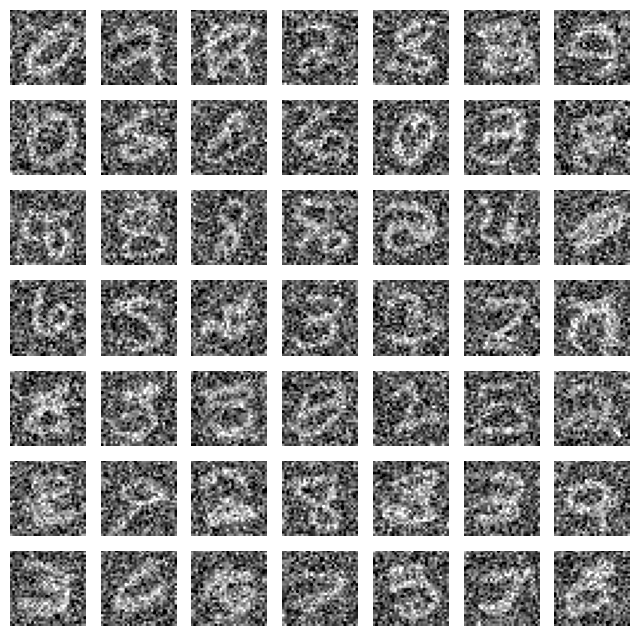

In [8]:
show_images(generated[759])

In [4]:
generate_video(generated, num_timesteps, file_title='arccos-0.999-evolution')

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [17]:
save_model(model, 'arccos-0.999')

In [16]:
def save_model(model, filename):
    torch.save({
        'model_state_dict': model.state_dict()
    }, f'models/{filename}.pt')